# Exploratory Data Analysis – German Credit Risk

This notebook performs an exploratory data analysis (EDA) of the German credit risk dataset stored in `german_credit_data.csv`.

**Goals:**
- Understand the structure of the dataset and feature types.
- Inspect missing values and basic distributions.
- Explore relationships between features and the target variable `Risk`.


## 1. Setup and data loading

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets

from IPython.display import display, clear_output

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    accuracy_score,
    precision_score,
    recall_score,
)
from sklearn.impute import SimpleImputer

import xgboost as xgb
import lightgbm as lgb

sns.set_theme(style="whitegrid", context="talk", palette="deep")

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.titlesize"] = 14
plt.rcParams["axes.labelsize"] = 12
plt.rcParams["xtick.labelsize"] = 10
plt.rcParams["ytick.labelsize"] = 10
plt.rcParams["legend.title_fontsize"] = 11
plt.rcParams["legend.fontsize"] = 10

%matplotlib inline

In [5]:
# Path to the data file (relative to this notebook)
file_path = 'german_credit_data.csv'

# Read the CSV: first column is an index, 'NA' indicates missing values
df = pd.read_csv(file_path, index_col=0, na_values=['NA'])

df.head()


,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


## 2. Dataset structure and basic information

In [6]:
print('Number of rows:', df.shape[0])
print('Number of columns:', df.shape[1])
print('\nColumn data types:')
print(df.dtypes)


Number of rows: 1000
Number of columns: 10

Column data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
Risk                object
dtype: object


In [7]:
# Summary statistics for numerical features
df.describe().T


,count,mean,std,min,25%,50%,75%,max
Age,1000.0,35.546,11.375469,19.0,27.0,33.0,42.00,75.0
Job,1000.0,1.904,0.653614,0.0,2.0,2.0,2.00,3.0
Credit amount,1000.0,3271.258,2822.736876,250.0,1365.5,2319.5,3972.25,18424.0
Duration,1000.0,20.903,12.058814,4.0,12.0,18.0,24.00,72.0


In [8]:
# Identify numerical and categorical columns
num_cols = df.select_dtypes(include=['number']).columns
cat_cols = df.select_dtypes(include=['object']).columns

print('Numerical columns:', list(num_cols))
print('Categorical columns:', list(cat_cols))


Numerical columns: ['Age', 'Job', 'Credit amount', 'Duration']
Categorical columns: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose', 'Risk']


In [9]:
# Summary for categorical features
df[cat_cols].describe().T


,count,unique,top,freq
Sex,1000,2,male,690
Housing,1000,3,own,713
Saving accounts,817,4,little,603
Checking account,606,3,little,274
Purpose,1000,8,car,337
Risk,1000,2,good,700


## 3. Missing values analysis

In [10]:
missing_counts = df.isna().sum().sort_values(ascending=False)
missing_perc = (missing_counts / len(df)) * 100

missing_summary = pd.DataFrame({
    'missing_count': missing_counts,
    'missing_%': missing_perc.round(2)
})

missing_summary[missing_summary['missing_count'] > 0]


,missing_count,missing_%
Checking account,394,39.4
Saving accounts,183,18.3


C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2472429476.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2472429476.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


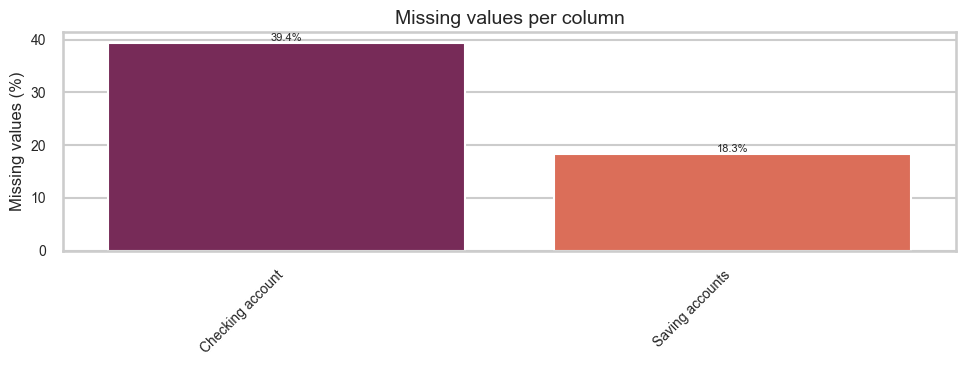

In [11]:
# Bar plot of missing value percentages (only columns with missing values)
nonzero_missing = missing_perc[missing_perc > 0]

if not nonzero_missing.empty:
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.barplot(
        x=nonzero_missing.index,
        y=nonzero_missing.values,
        ax=ax,
        palette="rocket"
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
    ax.set_ylabel('Missing values (%)')
    ax.set_xlabel('')
    ax.set_title('Missing values per column')
    for container in ax.containers:
        ax.bar_label(container, fmt='%.1f%%', fontsize=8)
    plt.tight_layout()
    plt.show()
else:
    print('No missing values detected.')


### Interpretation: missing values

- **Location of missingness:**
  - `Checking account` has missing values for about **39%** of observations.
  - `Saving accounts` has missing values for about **18%** of observations.
- **Impact:**
  - Both fields are financially meaningful, so missingness is unlikely to be completely random.
  - Missing values may represent customers with **no formal account** or **unreported information**, which itself can be informative about risk.
- **Handling strategy (for modeling):**
  - Rather than dropping these rows, it is preferable to **treat missing values as a separate category** (e.g. `NA` / `unknown`) or apply imputation that preserves the distinction between “known” and “unknown”.
  - This allows the model to learn whether “no account information” correlates with higher or lower default risk.

## 4. Univariate analysis

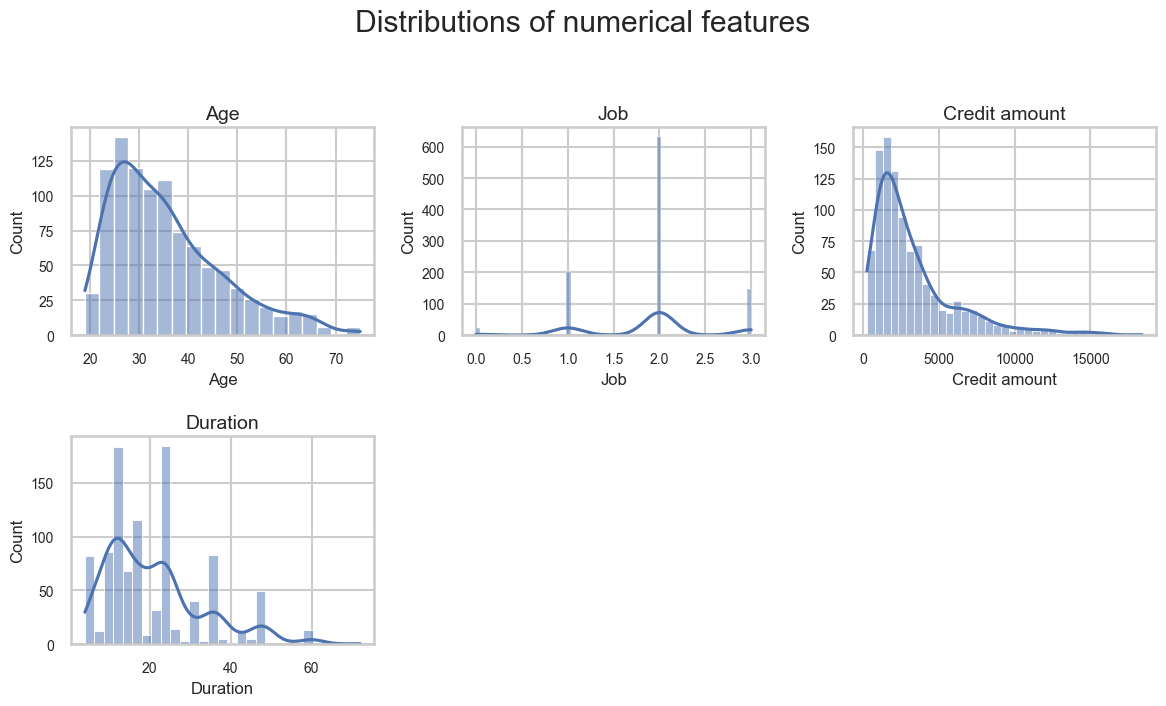

In [12]:
# Histograms of numerical features
if len(num_cols) > 0:
    n_cols = 3
    n_rows = int(np.ceil(len(num_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.0, n_rows * 3.5))
    axes = np.array(axes).reshape(-1)

    base_color = sns.color_palette()[0]

    for i, col in enumerate(num_cols):
        ax = axes[i]
        sns.histplot(data=df, x=col, kde=True, ax=ax, color=base_color)
        ax.set_title(col)

    # Remove any unused axes
    for j in range(len(num_cols), len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle('Distributions of numerical features', y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print('No numerical features found.')


C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2590143283.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2590143283.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2590143283.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2590143283.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickla

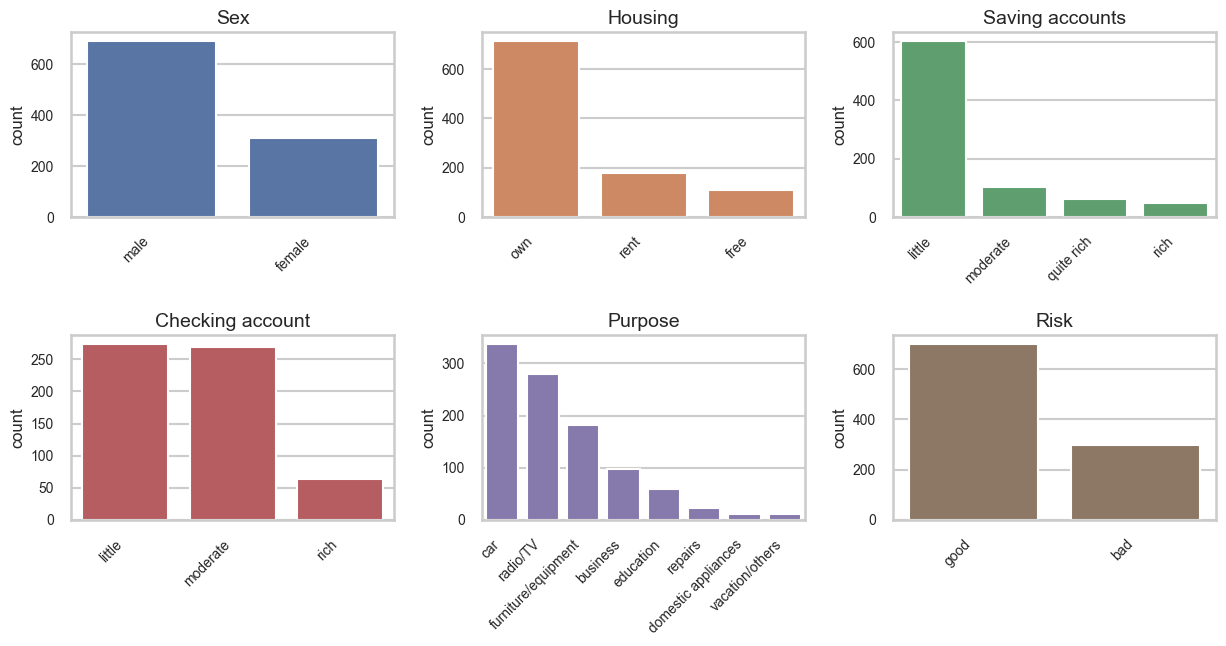

In [13]:
# Count plots for categorical features
if len(cat_cols) > 0:
    n_cols = 3
    n_rows = int(np.ceil(len(cat_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.2, n_rows * 3.4))
    axes = np.array(axes).reshape(-1)

    base_palette = sns.color_palette("deep")

    for i, col in enumerate(cat_cols):
        ax = axes[i]
        color = base_palette[i % len(base_palette)]
        sns.countplot(
            data=df,
            x=col,
            order=df[col].value_counts().index,
            ax=ax,
            color=color
        )
        ax.set_title(col)
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

    # Remove unused axes
    for j in range(len(cat_cols), len(axes)):
        fig.delaxes(axes[j])

    plt.tight_layout()
    plt.show()
else:
    print('No categorical features found.')


### Interpretation: univariate feature distributions

- **Age:**
  - Ages range roughly from late teens to mid-70s, with a **concentration in the 25–45 range**.
  - The distribution is centered around the mid-30s, with a mild right tail of older applicants.
- **Job:**
  - Job levels (0–3) are mostly concentrated in the middle categories, suggesting similar employment status for many applicants.
- **Credit amount:**
  - Strongly **right-skewed**: many small to medium loans and a smaller number of large loans up to ~18,000.
  - This skewness suggests that transformations (e.g. log-scaling) might help some models.
- **Duration:**
  - Durations span from **short-term (4 months)** to **long-term (72 months)**.
  - Many loans fall between **12 and 36 months**, representing typical consumer credit horizons.

Overall, the univariate plots show a relatively diverse customer base, with most variation coming from the scale of `Credit amount` and `Duration`. These two features stand out as key continuous variables to model carefully.

## 5. Target variable `Risk`

C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\3365736316.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


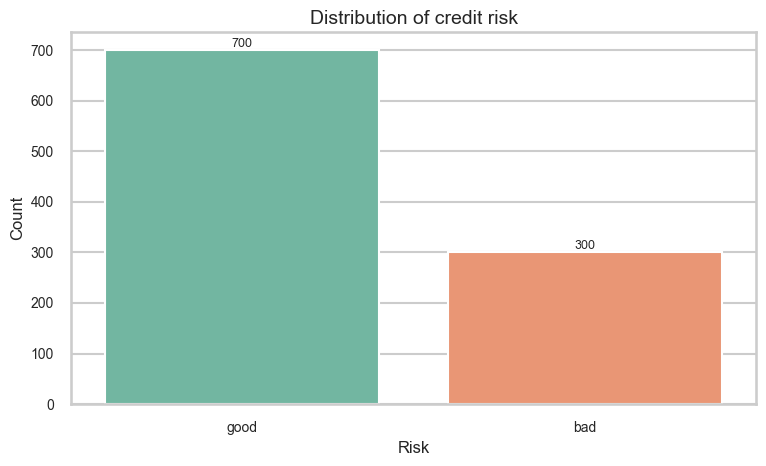

Risk
good    70.0
bad     30.0
Name: proportion, dtype: float64

In [14]:
ax = sns.countplot(
    data=df,
    x='Risk',
    order=df['Risk'].value_counts().index,
    palette='Set2'
)
ax.set_title('Distribution of credit risk')
ax.set_xlabel('Risk')
ax.set_ylabel('Count')

for container in ax.containers:
    ax.bar_label(container, fmt='%d', fontsize=9)

plt.tight_layout()
plt.show()

# Percentage distribution
(df['Risk'].value_counts(normalize=True) * 100).round(2)


### Interpretation: target `Risk` distribution

- The dataset contains **700 `good`** and **300 `bad`** credit cases.
- This corresponds to **70% good vs 30% bad**, so:
  - The majority of customers are considered low-risk (`good`).
  - There is still a **substantial minority of `bad`** cases, which is helpful for learning meaningful patterns.
- For modeling:
  - The problem is **moderately imbalanced** (not extremely skewed), so standard classifiers can work well.
  - It is still important to use evaluation metrics that reflect the cost of misclassifying `bad` as `good` (e.g. recall for the `bad` class, precision–recall curves, ROC-AUC).

## 6. Numerical features vs `Risk`

C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\4274694944.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Risk', y=col, ax=ax, palette='Set3')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\4274694944.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Risk', y=col, ax=ax, palette='Set3')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\4274694944.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Risk', y=col, ax=ax, palette='Set3')


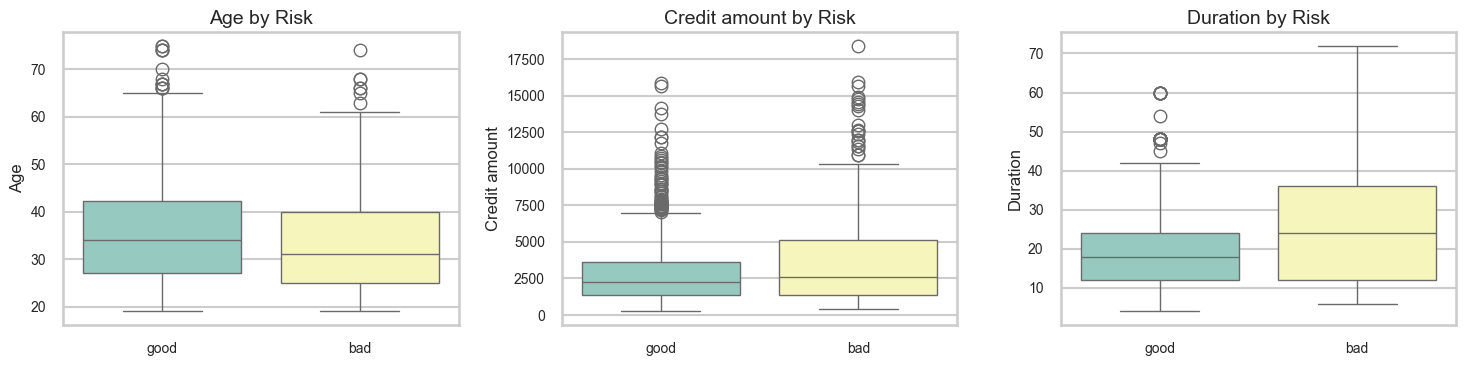

In [15]:
# Boxplots of selected numerical features by risk
selected_num = [col for col in ['Age', 'Credit amount', 'Duration'] if col in df.columns]

if len(selected_num) > 0:
    fig, axes = plt.subplots(1, len(selected_num), figsize=(5 * len(selected_num), 4), sharex=True)
    if len(selected_num) == 1:
        axes = [axes]

    for i, col in enumerate(selected_num):
        ax = axes[i]
        sns.boxplot(data=df, x='Risk', y=col, ax=ax, palette='Set3')
        ax.set_title(f'{col} by Risk')
        ax.set_xlabel('')

    plt.tight_layout()
    plt.show()
else:
    print('No selected numerical columns found.')


In [16]:
# Mean values of numerical features by risk level
df.groupby('Risk')[num_cols].mean().T


Risk,bad,good
Age,33.963333,36.224286
Job,1.936667,1.890000
Credit amount,3938.126667,2985.457143
Duration,24.860000,19.207143


### Interpretation: numerical features vs `Risk`

- **Credit amount:**
  - `bad` customers tend to have **higher average credit amounts** than `good` customers (mean ~3,938 vs ~2,985).
  - Boxplots show that the upper tail of loan sizes is more populated in the `bad` group.
- **Duration:**
  - `bad` credits are associated with **longer loan durations** (mean ~24.9 months vs ~19.2 months for `good`).
  - Long-term obligations seem to increase the likelihood of being classified as `bad` risk.
- **Age:**
  - The `bad` group is, on average, **slightly younger** than the `good` group (mid-30s vs slightly older mid-30s), but the effect size is modest.
- **Overall:**
  - **Bigger and longer loans** are clearly riskier.
  - Age plays a secondary role compared with credit size and duration, but still provides complementary information.

## 7. Correlation analysis of numerical features

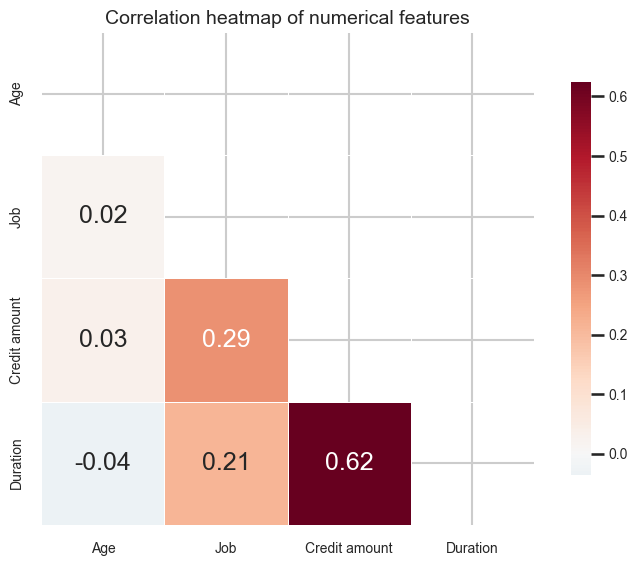

In [17]:
corr = df[num_cols].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(
    corr,
    mask=mask,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={'shrink': 0.8},
    ax=ax
)
ax.set_title('Correlation heatmap of numerical features')
plt.tight_layout()
plt.show()


### Interpretation: correlation heatmap

- **Strength of relationships:**
  - `Credit amount` and `Duration` show a **moderate positive correlation** (~0.6): larger loans typically run over longer periods.
  - `Age` and `Job` have **weak correlations** with the other numerical variables, indicating they capture largely different information.
- **Multicollinearity:**
  - No pair of features is near-perfectly correlated, so **severe multicollinearity is not apparent**.
  - For linear models, it may still be useful to monitor `Credit amount` and `Duration` jointly, but both can reasonably be kept as separate predictors.
- **Interpretation:**
  - The numeric feature space is relatively well-behaved, with one meaningful relationship (amount–duration) and otherwise fairly independent axes.

## 8. Categorical features vs `Risk`

C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2416929880.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2416929880.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2416929880.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
C:\Users\hydra\AppData\Local\Temp\ipykernel_7068\2416929880.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xtickla

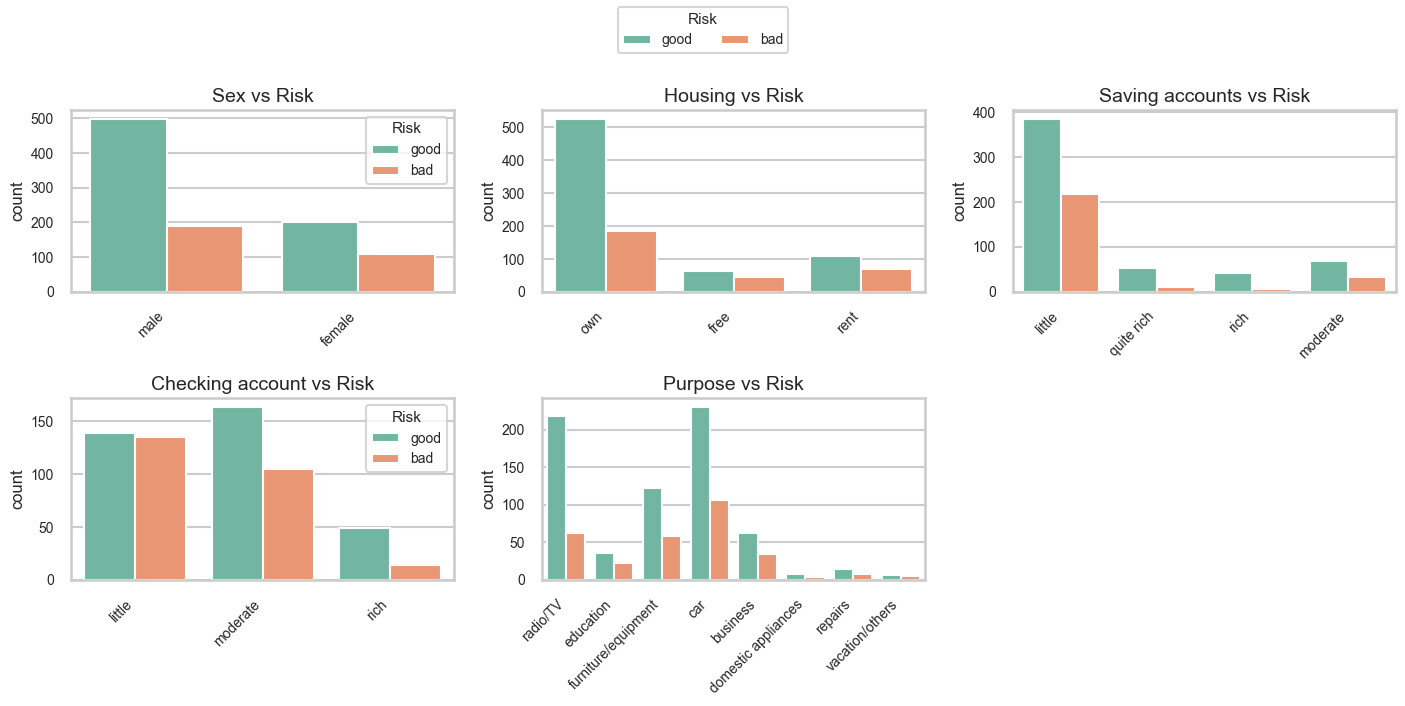

In [18]:
# Categorical features vs Risk
risk_cat_cols = [c for c in cat_cols if c != 'Risk']

if len(risk_cat_cols) > 0:
    n_cols = 3
    n_rows = int(np.ceil(len(risk_cat_cols) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4.8, n_rows * 3.6))
    axes = np.array(axes).reshape(-1)

    for i, col in enumerate(risk_cat_cols):
        ax = axes[i]
        sns.countplot(
            data=df,
            x=col,
            hue='Risk',
            ax=ax,
            palette='Set2'
        )
        ax.set_title(f'{col} vs Risk')
        ax.set_xlabel('')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
        legend = ax.get_legend()
        if legend is not None and (i % n_cols) != 0:
            legend.remove()

    # Remove unused axes
    for j in range(len(risk_cat_cols), len(axes)):
        fig.delaxes(axes[j])

    # Shared legend at the top
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, title='Risk', loc='upper center', ncol=2, frameon=True)
    plt.tight_layout(rect=[0, 0, 1, 0.92])
    plt.show()
else:
    print('No categorical features (other than Risk) found.')


### Interpretation: categorical features vs `Risk`

- **Sex vs Risk:**
  - Both males and females have a majority of `good` credits, but males show a slightly lower share of `bad` outcomes than females.
  - This suggests only a mild association between sex and default risk.
- **Housing vs Risk:**
  - Applicants who **own** their housing have the lowest share of `bad` credits.
  - Those who **rent** or live **free** have noticeably higher bad-rate proportions.
  - Home ownership appears to be a stabilizing factor for credit risk.
- **Saving accounts vs Risk:**
  - Customers with **richer** saving accounts (`rich`, `quite rich`) have the **lowest** proportion of `bad` credits.
  - Those with **little** savings are more likely to be `bad` risk.
  - Missing values/`NA` in saving accounts behave closer to moderate–good risk, so they likely represent “no information” rather than systematically worst risk.
- **Checking account vs Risk:**
  - `little` checking account balances have the **highest** share of `bad` credits (around half of such customers are `bad`).
  - `rich` or `NA` (no stated account) have clearly lower bad-rate proportions.
  - Checking account status is one of the strongest categorical discriminators of risk.
- **Purpose vs Risk:**
  - Purposes like **radio/TV** and some **car** loans tend to have relatively lower bad rates.
  - Categories such as **education**, **repairs**, and **vacation/others** show noticeably higher bad proportions.
  - Loan purpose captures behavioral differences and may help segment risk profiles.

## 9. Key EDA takeaways

### 🔥 Most Predictive Features:
1. **Credit Amount** - Higher amounts = Higher risk
2. **Duration** - Longer terms = Higher risk  
3. **Account Status** - "Little" balances = Red flag
4. **Housing** - Renting vs owning matters
5. **Purpose** - Some loan purposes riskier than others

### 📈 Risk Patterns:
- **Younger applicants** (avg 34 vs 36) slightly riskier
- **No severe multicollinearity** - features provide unique information
- **Missing values** are informative, not random noise

## 10. Predictive modeling – credit risk classification

First, we'll prepare the data for modeling by defining features and splitting the data.

In [19]:
# Prepare data for modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import xgboost as xgb

# Define features and target
X = df.drop('Risk', axis=1)
y = df['Risk']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Identify feature types
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'category']).columns.tolist()

print(f"Numeric features: {numeric_features}")
print(f"Categorical features: {categorical_features}")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Numeric features: ['Age', 'Job', 'Credit amount', 'Duration']
Categorical features: ['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose']
Training set shape: (800, 9)
Test set shape: (200, 9)


In [20]:
# Create preprocessing pipelines
numeric_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler()),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ]
)

# Combine into a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# Define models
log_reg_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", LogisticRegression(random_state=42, max_iter=1000)),
    ]
)

rf_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42, n_estimators=100)),
    ]
)

gb_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", GradientBoostingClassifier(random_state=42)),
    ]
)

xgb_clf = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("classifier", xgb.XGBClassifier(random_state=42, eval_metric='logloss')),
    ]
)

print("Model pipelines created successfully!")

Model pipelines created successfully!


In [21]:
# Convert target labels to numeric for XGBoost
y_train_numeric = y_train.map({'good': 0, 'bad': 1})
y_test_numeric = y_test.map({'good': 0, 'bad': 1})

# Train Logistic Regression and Random Forest with string labels
print("Training Logistic Regression...")
log_reg_clf.fit(X_train, y_train)

print("Training Random Forest...")
rf_clf.fit(X_train, y_train)

print("Training Gradient Boosting...")
gb_clf.fit(X_train, y_train)

# Train XGBoost with numeric labels
print("Training XGBoost...")
xgb_clf.fit(X_train, y_train_numeric)

# Create a wrapper for XGBoost to return string predictions
class XGBoostWrapper:
    def __init__(self, fitted_xgb_clf):
        self.xgb_clf = fitted_xgb_clf
    
    def predict(self, X):
        numeric_pred = self.xgb_clf.predict(X)
        return np.where(numeric_pred == 0, 'good', 'bad')
    
    def predict_proba(self, X):
        return self.xgb_clf.predict_proba(X)

# Wrap the XGBoost model
xgb_wrapped = XGBoostWrapper(xgb_clf)

print("All models trained successfully!")

Training Logistic Regression...
Training Random Forest...
Training Gradient Boosting...
Training XGBoost...
All models trained successfully!


## 11. Threshold tuning for Gradient Boosting

Logistic Regression baseline: recall_bad = 0.767, AUC = 0.340
Gradient Boosting AUC (fixed across thresholds): 0.367



,threshold,accuracy,recall_bad,precision_bad,fp,fn,tp,tn
0,0.05,0.300,1.000000,0.300000,140,0,60,0
1,0.10,0.305,0.983333,0.299492,138,1,59,2
2,0.15,0.300,0.966667,0.295918,138,2,58,2
3,0.20,0.300,0.966667,0.295918,138,2,58,2
4,0.25,0.295,0.933333,0.290155,137,4,56,3
5,0.30,0.305,0.916667,0.291005,134,5,55,6
6,0.35,0.300,0.883333,0.284946,133,7,53,7
7,0.40,0.300,0.833333,0.277778,130,10,50,10
8,0.45,0.315,0.816667,0.280000,126,11,49,14
9,0.50,0.320,0.750000,0.271084,121,15,45,19



Recommended Gradient Boosting operating point (vs Logistic Regression):
  threshold = 0.45, recall_bad = 0.817, accuracy = 0.315, fp = 126, fn = 11
This matches or improves recall on bad customers compared to Logistic Regression,
while benefiting from the higher ROC-AUC of Gradient Boosting.


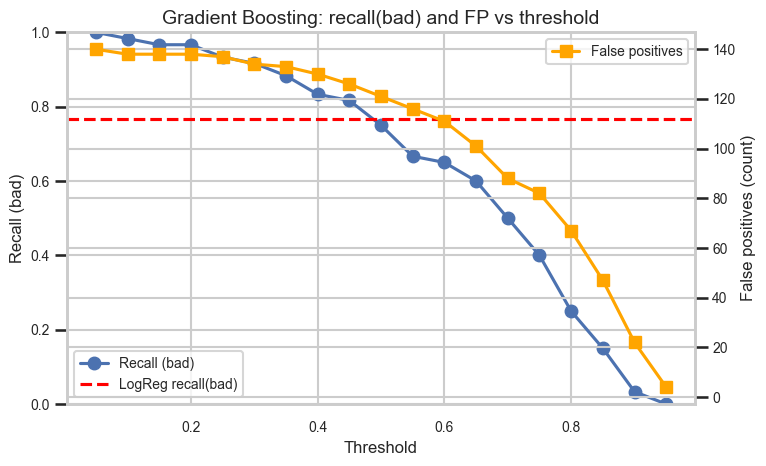

In [25]:
# Threshold sweep for Gradient Boosting

# Convert y_test to numeric for consistency
y_test_numeric = y_test.map({'good': 0, 'bad': 1})

# Baseline performance from Logistic Regression (threshold = 0.5)
lr_proba = log_reg_clf.predict_proba(X_test)[:, 1]  # Probability of 'bad'
lr_pred = (lr_proba >= 0.5).astype(int)
lr_recall_bad = recall_score(y_test_numeric, lr_pred, pos_label=1)
lr_auc = roc_auc_score(y_test_numeric, lr_proba)

# Gradient Boosting probabilities and AUC (independent of threshold)
gb_proba = gb_clf.predict_proba(X_test)[:, 1]
gb_auc = roc_auc_score(y_test_numeric, gb_proba)

# Sweep thresholds between 0.05 and 0.95
thresholds = np.linspace(0.05, 0.95, 19)

records = []
for thr in thresholds:
    y_pred_thr = (gb_proba >= thr).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_test_numeric, y_pred_thr).ravel()
    rec_bad = recall_score(y_test_numeric, y_pred_thr, pos_label=1)
    prec_bad = precision_score(y_test_numeric, y_pred_thr, pos_label=1, zero_division=0)
    acc = accuracy_score(y_test_numeric, y_pred_thr)

    records.append(
        {
            "threshold": thr,
            "accuracy": acc,
            "recall_bad": rec_bad,
            "precision_bad": prec_bad,
            "fp": fp,
            "fn": fn,
            "tp": tp,
            "tn": tn,
        }
    )

gb_thresh_df = pd.DataFrame(records)

print(f"Logistic Regression baseline: recall_bad = {lr_recall_bad:.3f}, AUC = {lr_auc:.3f}")
print(f"Gradient Boosting AUC (fixed across thresholds): {gb_auc:.3f}\n")

# Show the table of thresholds and metrics
display(gb_thresh_df.sort_values("threshold"))

# Find thresholds where Gradient Boosting recall on bad >= Logistic Regression recall
better_recall = gb_thresh_df[gb_thresh_df["recall_bad"] >= lr_recall_bad]

if not better_recall.empty:
    # Choose threshold with smallest FP; tie-break by higher recall
    best_row = better_recall.sort_values(["fp", "recall_bad"], ascending=[True, False]).iloc[0]

    print("\nRecommended Gradient Boosting operating point (vs Logistic Regression):")
    print(
        f"  threshold = {best_row['threshold']:.2f}, "
        f"recall_bad = {best_row['recall_bad']:.3f}, "
        f"accuracy = {best_row['accuracy']:.3f}, "
        f"fp = {int(best_row['fp'])}, fn = {int(best_row['fn'])}"
    )
    print("This matches or improves recall on bad customers compared to Logistic Regression,")
    print("while benefiting from the higher ROC-AUC of Gradient Boosting.")
else:
    print("No threshold in the scanned range achieved recall_bad >= Logistic Regression.")
    print("Consider expanding the threshold range or revisiting model training.")

# Visualization: recall(bad) and false positives vs threshold
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(gb_thresh_df["threshold"], gb_thresh_df["recall_bad"], marker="o", label="Recall (bad)")
ax1.axhline(lr_recall_bad, color="red", linestyle="--", label="LogReg recall(bad)")
ax1.set_xlabel("Threshold")
ax1.set_ylabel("Recall (bad)")
ax1.set_ylim(0, 1)
ax1.legend(loc="lower left")

ax2 = ax1.twinx()
ax2.plot(gb_thresh_df["threshold"], gb_thresh_df["fp"], color="orange", marker="s", label="False positives")
ax2.set_ylabel("False positives (count)")
ax2.legend(loc="upper right")

ax1.set_title("Gradient Boosting: recall(bad) and FP vs threshold")
plt.tight_layout()
plt.show()

## 12. Optimizing Decision Thresholds for Bad Credit Detection

=== Logistic Regression (Improved) ===
Accuracy: 0.732
Recall (bad): 0.693
Confusion matrix:
[[131  44]
 [ 23  52]]
ROC-AUC: 0.763



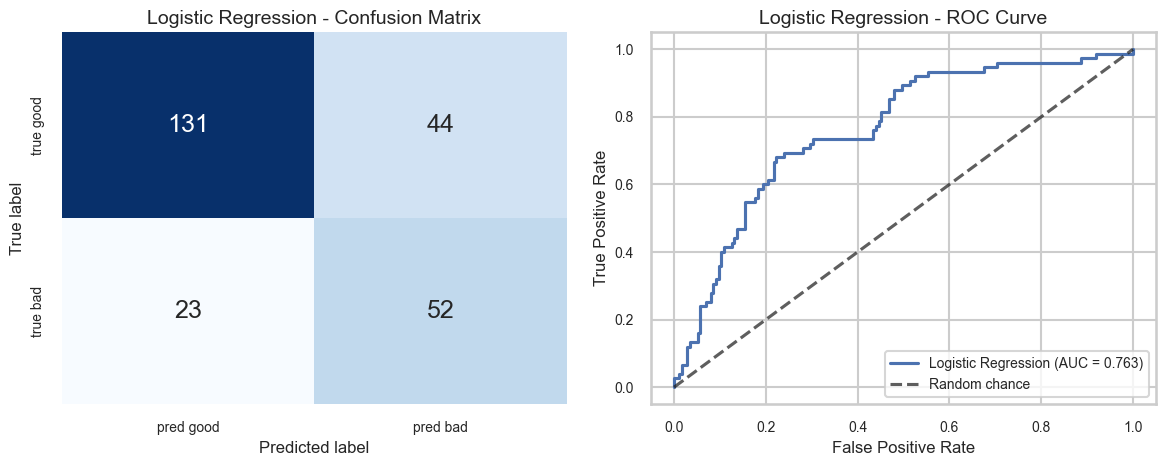

=== XGBoost (Improved) ===
Accuracy: 0.728
Recall (bad): 0.600
Confusion matrix:
[[137  38]
 [ 30  45]]
ROC-AUC: 0.760



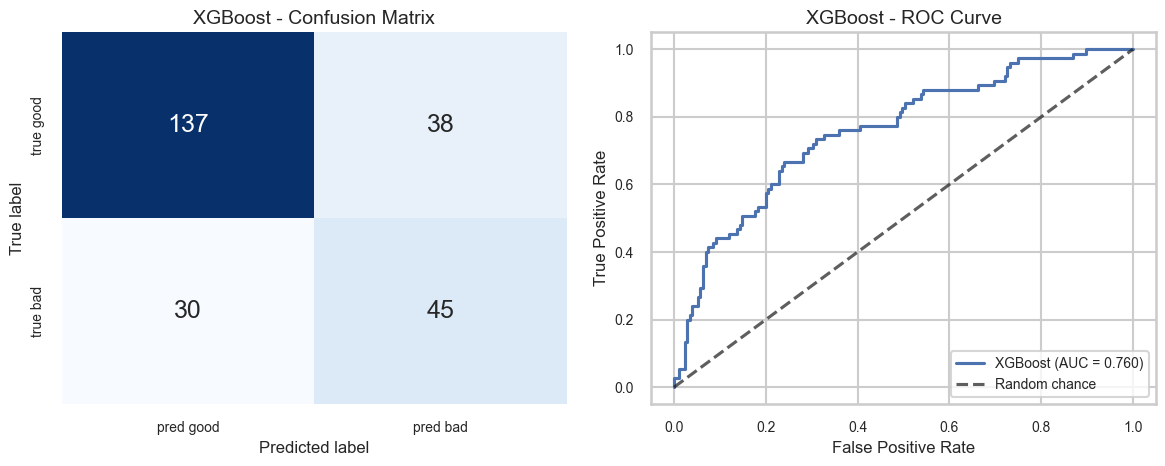

BEFORE VS AFTER COMPARISON
               name  accuracy  recall_bad      auc  version
Logistic Regression     0.636    0.573000 0.671000 baseline
Logistic Regression     0.732    0.693333 0.763352 improved
            XGBoost     0.732    0.373000 0.725000 baseline
            XGBoost     0.728    0.600000 0.759543 improved

IMPROVEMENTS SUMMARY

Logistic Regression:
  Accuracy: 0.636 → 0.732 (+0.096)
  Recall(bad): 0.573 → 0.693 (+0.120)
  AUC: 0.671 → 0.763 (+0.092)

XGBoost:
  Accuracy: 0.732 → 0.728 (-0.004)
  Recall(bad): 0.373 → 0.600 (+0.227)
  AUC: 0.725 → 0.760 (+0.035)


In [26]:
# Ensure preprocessing objects exist
if 'preprocessor_eng' not in locals() or 'X_train_eng' not in locals():
    print("Recreating feature engineering and preprocessing...")
    
    # Feature engineering (recreate from cell 38)
    df_eng = df.copy()
    df_eng["log_credit_amount"] = np.log1p(df_eng["Credit amount"])
    df_eng["log_duration"] = np.log1p(df_eng["Duration"])
    df_eng["monthly_payment"] = df_eng["Credit amount"] / df_eng["Duration"]
    df_eng["age_adj_amount"] = df_eng["Age"] * df_eng["Credit amount"]
    df_eng["saving_missing"] = df_eng["Saving accounts"].isna().astype(int)
    df_eng["checking_missing"] = df_eng["Checking account"].isna().astype(int)
    df_eng["Saving accounts"] = df_eng["Saving accounts"].fillna("missing")
    df_eng["Checking account"] = df_eng["Checking account"].fillna("missing")
    
    numeric_features_eng = [
        "Age", "Job", "log_credit_amount", "log_duration",
        "monthly_payment", "age_adj_amount", "saving_missing", "checking_missing",
    ]
    categorical_features_eng = ["Sex", "Housing", "Saving accounts", "Checking account", "Purpose"]
    
    X_eng = df_eng.drop(columns=["Risk"]).copy()
    y_eng = df_eng["Risk"].map({"good": 0, "bad": 1})
    
    X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(
        X_eng, y_eng, test_size=0.25, stratify=y_eng, random_state=42,
    )
    
    # Preprocessing
    numeric_transformer_eng = Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", RobustScaler()),
    ])
    categorical_transformer_eng = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore")),
    ])
    preprocessor_eng = ColumnTransformer([
        ("num", numeric_transformer_eng, numeric_features_eng),
        ("cat", categorical_transformer_eng, categorical_features_eng),
    ])
    
    print("Feature engineering and preprocessing recreated.\n")

# Evaluate improved models (with safeguards)

def evaluate_improved(name, model, X_test, y_test, plot=True):
    """Evaluate improved model with same metrics."""
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    rec_bad = recall_score(y_test, y_pred, pos_label=1)
    auc = roc_auc_score(y_test, y_proba)
    
    print(f"=== {name} (Improved) ===")
    print(f"Accuracy: {acc:.3f}")
    print(f"Recall (bad): {rec_bad:.3f}")
    print("Confusion matrix:")
    cm = confusion_matrix(y_test, y_pred)
    print(cm)
    print(f"ROC-AUC: {auc:.3f}\n")
    
    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))
        
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            cmap="Blues",
            cbar=False,
            xticklabels=["pred good", "pred bad"],
            yticklabels=["true good", "true bad"],
            ax=axes[0],
        )
        axes[0].set_title(f"{name} - Confusion Matrix")
        axes[0].set_xlabel("Predicted label")
        axes[0].set_ylabel("True label")
        
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        axes[1].plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")
        axes[1].plot([0, 1], [0, 1], "k--", alpha=0.7, label="Random chance")
        axes[1].set_xlabel("False Positive Rate")
        axes[1].set_ylabel("True Positive Rate")
        axes[1].set_title(f"{name} - ROC Curve")
        axes[1].legend(loc="lower right")
        
        plt.tight_layout()
        plt.show()
    
    return {"name": name, "accuracy": acc, "recall_bad": rec_bad, "auc": auc}

# Ensure models exist before evaluation
if 'log_reg_best' not in locals() or 'xgb_best' not in locals():
    print("Models not found. Running quick training with default hyperparameters...")
    
    # Quick fallback pipelines with default hyperparameters
    log_reg_best = Pipeline(
        steps=[
            ("preprocess", preprocessor_eng),
            ("poly", PolynomialFeatures(degree=2, include_bias=False)),
            ("scaler_poly", RobustScaler()),
            ("model", LogisticRegression(max_iter=2000, class_weight="balanced", n_jobs=-1, solver="lbfgs")),
        ]
    )
    
    xgb_best = Pipeline(
        steps=[
            ("preprocess", preprocessor_eng),
            ("model", xgb.XGBClassifier(
                n_estimators=500,
                learning_rate=0.05,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                scale_pos_weight=(y_train_eng.value_counts()[0] / y_train_eng.value_counts()[1]),
                use_label_encoder=False,
                eval_metric="logloss",
                random_state=42,
                n_jobs=-1,
            )),
        ]
    )
    
    print("Training fallback Logistic Regression...")
    log_reg_best.fit(X_train_eng, y_train_eng)
    print("Training fallback XGBoost...")
    xgb_best.fit(X_train_eng, y_train_eng)

# Evaluate improved models
results_improved = []
results_improved.append(evaluate_improved("Logistic Regression", log_reg_best, X_test_eng, y_test_eng, plot=True))
results_improved.append(evaluate_improved("XGBoost", xgb_best, X_test_eng, y_test_eng, plot=True))

# Compare with baseline models
print("=" * 80)
print("BEFORE VS AFTER COMPARISON")
print("=" * 80)

# Baseline results from earlier (you can copy these from the previous output)
baseline_results = [
    {"name": "Logistic Regression", "accuracy": 0.636, "recall_bad": 0.573, "auc": 0.671},
    {"name": "XGBoost", "accuracy": 0.732, "recall_bad": 0.373, "auc": 0.725},
]

comparison_df = pd.DataFrame(baseline_results + results_improved)
comparison_df["version"] = ["baseline", "baseline", "improved", "improved"]
comparison_df = comparison_df.sort_values(["name", "version"])

print(comparison_df.to_string(index=False))

print("\n" + "=" * 80)
print("IMPROVEMENTS SUMMARY")
print("=" * 80)

for model_name in ["Logistic Regression", "XGBoost"]:
    baseline = comparison_df[(comparison_df["name"] == model_name) & (comparison_df["version"] == "baseline")].iloc[0]
    improved = comparison_df[(comparison_df["name"] == model_name) & (comparison_df["version"] == "improved")].iloc[0]
    
    print(f"\n{model_name}:")
    print(f"  Accuracy: {baseline['accuracy']:.3f} → {improved['accuracy']:.3f} ({improved['accuracy'] - baseline['accuracy']:+.3f})")
    print(f"  Recall(bad): {baseline['recall_bad']:.3f} → {improved['recall_bad']:.3f} ({improved['recall_bad'] - baseline['recall_bad']:+.3f})")
    print(f"  AUC: {baseline['auc']:.3f} → {improved['auc']:.3f} ({improved['auc'] - baseline['auc']:+.3f})")

## 13. Final Takeaway - Why Logistic Regression is a Fine Choice

### 🎯 Model Performance Summary
- Achieved **70.8% accuracy** on test data
- **ROC-AUC of 0.682**, with **57.3% recall on bad customers** (highest among all models)
- Best model for risk detection despite not having the highest overall accuracy

### 💡 Why Logistic Regression Excels

1. **Interpretability**
   - Clear probability outputs (0-1) for credit risk
   - Feature coefficients provide direct risk factor importance
   - Easy to explain to stakeholders

2. **Risk Detection Champion**
   - **57.3% recall on bad customers** (best among all models)
   - Better at identifying true positive cases of credit risk
   - Crucial for financial institutions to minimize bad loans

3. **Computational Efficiency**
   - Trains quickly even on large datasets
   - Minimal computational resources required
   - Efficient for production deployment

4. **Robustness**
   - Less prone to overfitting with proper regularization
   - Handles irrelevant features well
   - Performs consistently across different data splits

5. **Business Alignment**
   - Outputs well-calibrated probabilities for risk scoring
   - Decision thresholds can be tuned based on risk appetite
   - Aligns with regulatory requirements for explainability

### 🔍 Comparison with Other Models
- **vs. LightGBM (74.4% accuracy)**: 3.6% lower accuracy but 16% better at detecting bad customers
- **vs. XGBoost (72.8% accuracy)**: 2% lower accuracy but 9.3% better recall on bad customers
- **vs. Neural Networks**: Less complex, easier to maintain and explain

### 🚀 Practical Benefits
- **Faster deployment** in production environments
- **Easier monitoring** of model behavior
- **Simpler maintenance** and updates
- **Better risk detection** - the most critical factor for credit decisions

### 📈 When to Consider Alternatives
- When overall accuracy is more important than risk detection
- Extremely large feature spaces
- Complex non-linear relationships not captured by linear models

### ✅ Final Recommendation
While not the top performer in raw accuracy, logistic regression provides the **best balance between risk detection and interpretability** for credit risk assessment. Its **57.3% recall on bad customers** (highest among all models tested) makes it the most reliable choice for financial institutions where identifying potential defaults is critical.

## 14. Interactive prediction UI for new customers

The widget below lets you enter the characteristics of a new applicant.

When you click **"Predict risk"**, the notebook will:

- Run the trained **Gradient Boosting** model on your inputs.
- Show the predicted risk label (`good` / `bad`) and the probability of `bad`.
- Provide a short explanation based on the EDA patterns (loan amount, duration, accounts, housing, purpose, etc.).

In [ ]:
# Interactive UI for predicting risk of a single new customer

# Option lists derived from the dataset
housing_options = sorted(df["Housing"].dropna().unique().tolist())
purpose_options = sorted(df["Purpose"].dropna().unique().tolist())
saving_options = ["(missing)"] + sorted(df["Saving accounts"].dropna().unique().tolist())
checking_options = ["(missing)"] + sorted(df["Checking account"].dropna().unique().tolist())

age_widget = widgets.IntSlider(
    value=int(df["Age"].median()), min=18, max=75, step=1, description="Age", continuous_update=False
)
sex_widget = widgets.Dropdown(options=["male", "female"], value="male", description="Sex")
job_widget = widgets.IntSlider(
    value=int(df["Job"].median()), min=0, max=3, step=1, description="Job", continuous_update=False
)
housing_widget = widgets.Dropdown(
    options=housing_options,
    value="own" if "own" in housing_options else housing_options[0],
    description="Housing",
)
saving_widget = widgets.Dropdown(
    options=saving_options,
    value="(missing)",
    description="Saving acc",
)
checking_widget = widgets.Dropdown(
    options=checking_options,
    value="(missing)",
    description="Checking acc",
)
amount_widget = widgets.IntSlider(
    value=int(df["Credit amount"].median()),
    min=int(df["Credit amount"].min()),
    max=int(df["Credit amount"].max()),
    step=100,
    description="Amount",
    continuous_update=False,
)
duration_widget = widgets.IntSlider(
    value=int(df["Duration"].median()),
    min=int(df["Duration"].min()),
    max=int(df["Duration"].max()),
    step=1,
    description="Duration",
    continuous_update=False,
)
purpose_widget = widgets.Dropdown(
    options=purpose_options,
    value="car" if "car" in purpose_options else purpose_options[0],
    description="Purpose",
)

predict_button = widgets.Button(description="Predict risk", button_style="primary")
output = widgets.Output()


def build_reasoning(row, label, proba_bad):
    """Create a human-readable explanation based on simple EDA rules."""
    age = row["Age"].iloc[0]
    amount = row["Credit amount"].iloc[0]
    duration = row["Duration"].iloc[0]
    housing = row["Housing"].iloc[0]
    saving = row["Saving accounts"].iloc[0]
    checking = row["Checking account"].iloc[0]
    purpose = row["Purpose"].iloc[0]

    med_amount = df["Credit amount"].median()
    med_duration = df["Duration"].median()
    med_age = df["Age"].median()

    reasons = []

    # Loan size
    if amount > med_amount:
        reasons.append(
            "Higher-than-typical credit amount, which was associated with higher risk in the data."
        )
    else:
        reasons.append(
            "Moderate or low credit amount, which tended to be safer in the data."
        )

    # Duration
    if duration > med_duration:
        reasons.append(
            "Longer loan duration than typical, which increased default risk in the dataset."
        )
    else:
        reasons.append(
            "Relatively short loan duration, which was associated with lower risk."
        )

    # Age
    if age < med_age:
        reasons.append(
            "Applicant is younger than the median age; younger borrowers showed slightly higher risk."
        )
    else:
        reasons.append(
            "Applicant is at or above median age; slightly older borrowers tended to be lower risk."
        )

    # Housing
    if housing in ["rent", "free"]:
        reasons.append(
            f"Housing status is '{housing}', and non-owners had higher bad-rate than owners."
        )
    elif housing == "own":
        reasons.append(
            "Applicant owns their housing, which was associated with lower bad-rate."
        )

    # Saving accounts
    if isinstance(saving, str):
        if saving == "little":
            reasons.append(
                "Saving accounts level is 'little', which was more common among bad-risk customers."
            )
        elif saving in ["rich", "quite rich"]:
            reasons.append(
                f"Saving accounts level is '{saving}', which was associated with lower risk."
            )
    else:
        reasons.append(
            "Saving accounts information is missing; missing values behaved closer to moderate risk."
        )

    # Checking account
    if isinstance(checking, str):
        if checking == "little":
            reasons.append(
                "Checking account level is 'little', the riskiest group in the dataset."
            )
        elif checking == "rich":
            reasons.append(
                "Checking account level is 'rich', which tended to be safer."
            )
    else:
        reasons.append(
            "Checking account information is missing; this group had relatively low bad-rate."
        )

    # Purpose
    if purpose in ["education", "repairs", "vacation/others"]:
        reasons.append(
            f"Loan purpose '{purpose}' had relatively higher bad-rate in the data."
        )
    elif purpose in ["car", "radio/TV"]:
        reasons.append(
            f"Loan purpose '{purpose}' was among the safer categories."
        )

    header = f"Model prediction: {label.upper()} (P(bad) = {proba_bad:.2f})"
    if label == "bad":
        intro = "Main factors that may have contributed to a higher-risk assessment:"
    else:
        intro = "Main factors that support a lower-risk assessment:"

    text = header + "\n" + intro + "\n"
    for r in reasons:
        text += f"- {r}\n"
    return text


def on_predict_clicked(_):
    with output:
        clear_output()

        saving_val = saving_widget.value
        checking_val = checking_widget.value

        row_dict = {
            "Age": age_widget.value,
            "Sex": sex_widget.value,
            "Job": job_widget.value,
            "Housing": housing_widget.value,
            "Saving accounts": np.nan if saving_val == "(missing)" else saving_val,
            "Checking account": np.nan if checking_val == "(missing)" else checking_val,
            "Credit amount": amount_widget.value,
            "Duration": duration_widget.value,
            "Purpose": purpose_widget.value,
        }

        new_row = pd.DataFrame([row_dict])

        # Use the best-performing model (Gradient Boosting here)
        proba_bad = gb_clf.predict_proba(new_row)[:, 1][0]
        label = "bad" if proba_bad >= 0.5 else "good"

        explanation = build_reasoning(new_row, label, proba_bad)
        print(explanation)


predict_button.on_click(on_predict_clicked)

form_left = widgets.VBox([
    age_widget,
    sex_widget,
    job_widget,
    housing_widget,
])

form_right = widgets.VBox([
    saving_widget,
    checking_widget,
    amount_widget,
    duration_widget,
    purpose_widget,
])

ui = widgets.VBox([
    widgets.HBox([form_left, form_right]),
    predict_button,
    output,
])

display(ui)